In [55]:
import numpy as np
import os
import time
import random
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [56]:
batch_size = 32
img_height = 188
img_width = 114

data_dir_train = "mini_project_dataset/train"
data_dir_validation = "mini_project_dataset/validation"
data_dir_test = "mini_project_dataset/test"

In [57]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 988 files belonging to 2 classes.


In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_validation,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 2 classes.


In [59]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 2 classes.


In [60]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000).repeat(3)
    
    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_brightness(x, 0.2), y), num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


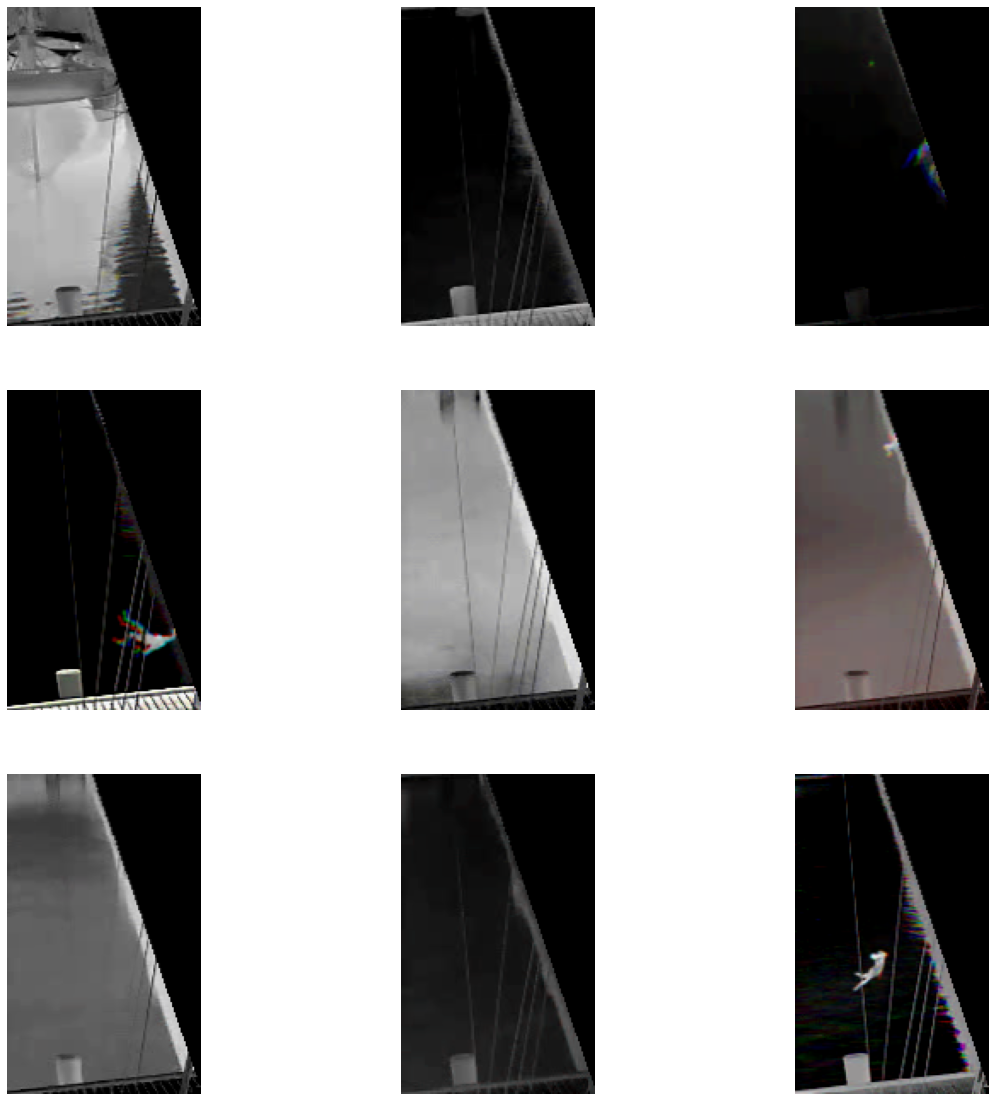

In [61]:
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

In [62]:
def make_model(lr=0.0001, activation="softmax", beta_2=0.999, epsilon=1e-07):
    num_classes = 2

    model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(16, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(num_classes, activation=activation)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=lr,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=False,
            name="Adam"),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    
    return model

In [63]:
model = make_model(lr=0.001, activation="sigmoid", beta_2=0.9999, epsilon=1e-08)

In [64]:
#model.load_weights('models/model')

In [65]:
if not os.path.exists('logs'):
    os.makedirs('logs')

root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
    run_id = "magnus model"
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [ ]:
run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40,
  callbacks=[tensorboard_cb, early_stopping_cb]
)

Epoch 1/40
93/93 [==============================] - 34s 331ms/step - loss: 0.5149 - accuracy: 0.7338 - val_loss: 0.3727 - val_accuracy: 0.8367
Epoch 2/40
93/93 [==============================] - 33s 338ms/step - loss: 0.3369 - accuracy: 0.8536 - val_loss: 0.3399 - val_accuracy: 0.8633
Epoch 3/40
 9/93 [=>............................] - ETA: 29s - loss: 0.2622 - accuracy: 0.9120

In [ ]:
model.save_weights('models/weights')

In [ ]:
results = model.evaluate(test_ds, batch_size=32)

In [ ]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Harbor fall detection\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['No Person','Person'])
ax.yaxis.set_ticklabels(['No Person','Person'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
#%tensorboard --logdir=./logs --port=6006